# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
final=final.sort_values(by='Time')

In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
labels= list(final['Score'])
final=final.drop("Score",axis=1)

(364171, 10)


In [17]:
final=final[0:50000]
labels=labels[0:50000]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!<br /><br />If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I 

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I can't believe that you can actually buy Coke products on Amazon!If I was going to order any soft drink online, it would be Diet Coke with Lime.  The lime improves the taste of Diet Coke signifigantally and makes the aftertaste (from the artificial sweetener) much less noticeable.  Coke has quite intelligently taken  one of the mixes that many beverage-drinkers have been enjoying for years and made it available as a consistently-mixed, no knife (to peel the lime) needed version!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited 

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:31<00:00, 1567.22it/s]


In [27]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

In [28]:
tr_indx=int(70/100*len(preprocessed_reviews))
X_tr=preprocessed_reviews[:tr_indx]
y_tr=labels[:tr_indx]
X_test=preprocessed_reviews[tr_indx+1:]
y_test=labels[tr_indx+1:]

In [29]:
print(len(X_tr))
print(len(X_test))
print(len(y_tr))
print(len(y_test))

35000
14999
35000
14999


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer(max_features = 2000) #in scikit-learn
final_counts = count_vect.fit_transform(X_tr)
final_test = count_vect.transform(X_test)
print("some feature names ", count_vect.get_feature_names()[:10])

some feature names  ['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'acids', 'acquired', 'across', 'actual']


In [31]:
print(final_counts.shape)
print(final_test.shape)

(35000, 2000)
(14999, 2000)


In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False,with_std=False)
final_counts = scaler.fit_transform( final_counts.astype('float') )
final_test = scaler.transform( final_test.astype('float') )

In [33]:

print('='*50)

count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (35000, 2000)
the number of unique words  2000


## [4.3] TF-IDF

In [34]:
tf_idf_vect = TfidfVectorizer(max_features = 2000)
final_tf_idf = tf_idf_vect.fit_transform(X_tr)
final_tf_test = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'acids', 'acquired', 'across', 'actual']


In [35]:
scaler = StandardScaler(with_mean=False,with_std=False)
final_tf_idf = scaler.fit_transform( final_tf_idf.astype('float') )
final_tf_test = scaler.transform( final_tf_test.astype('float') )

In [36]:
print(final_counts.shape)
print(final_test.shape)

(35000, 2000)
(14999, 2000)


## [4.4] Word2Vec

In [37]:
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())

In [38]:
list_of_test=[]
for sent in X_test:
    list_of_test.append(sent.split())

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.7960363626480103), ('fantastic', 0.777550220489502), ('good', 0.7745554447174072), ('wonderful', 0.7739193439483643), ('amazing', 0.7644571661949158), ('excellent', 0.7526196837425232), ('terrific', 0.7443751096725464), ('perfect', 0.6814810037612915), ('fabulous', 0.669648289680481), ('decent', 0.6384543180465698)]
[('greatest', 0.8334922790527344), ('best', 0.8002321124076843), ('closest', 0.7257724404335022), ('nicest', 0.7146831750869751), ('tastiest', 0.7086165547370911), ('disgusting', 0.7031144499778748), ('experienced', 0.6821959614753723), ('coolest', 0.6757559776306152), ('tasted', 0.6729488968849182), ('eaten', 0.6724807024002075)]


In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11557
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 35000/35000 [01:59<00:00, 291.72it/s]

35000
50


In [42]:
test_vectors = [];
for sent in tqdm(list_of_test): 
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

100%|██████████| 14999/14999 [00:57<00:00, 262.14it/s]


In [43]:
df = pd.DataFrame(sent_vectors)
sent_vectors=df.fillna(0).values
df = pd.DataFrame(test_vectors)
test_vectors=df.fillna(0).values

In [44]:
scaler = StandardScaler()
sent_vectors = scaler.fit_transform(sent_vectors)
test_vectors = scaler.transform(test_vectors)

#### [4.4.1.2] TFIDF weighted W2v

In [45]:
tfidf_model = TfidfVectorizer()
w2v_tf_idf = tfidf_model.fit_transform(X_tr)
w2v_tf_test = tfidf_model.transform(X_test)
print("some sample features(unique words in the corpus)",tfidf_model.get_feature_names()[0:10])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaah', 'aaah', 'aaahs', 'aachen', 'aadp']


In [46]:
tfidf_feat = tfidf_model.get_feature_names() 
tfidf_sent_vectors = [];
row=0;
i=1
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = w2v_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 35000/35000 [23:00<00:00, 31.53it/s] 


In [47]:
tfidf_feat = tfidf_model.get_feature_names()
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(list_of_test):
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = w2v_tf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

100%|██████████| 14999/14999 [10:34<00:00, 23.63it/s]


In [48]:
df = pd.DataFrame(tfidf_sent_vectors)
tfidf_sent_vectors=df.fillna(0).values
df = pd.DataFrame(tfidf_test_vectors)
tfidf_test_vectors=df.fillna(0).values

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tfidf_sent_vectors = scaler.fit_transform( tfidf_sent_vectors )
tfidf_test_vectors = scaler.transform( tfidf_test_vectors )

# [5] Assignment 3: KNN

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [52]:
from prettytable import PrettyTable
ptab = PrettyTable()
ptab.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]


The optimal number of k is 29.


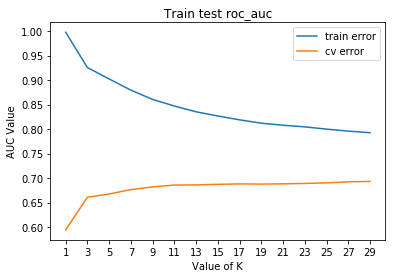

AUC for each K value is :  [0.594 0.661 0.668 0.677 0.682 0.686 0.686 0.687 0.688 0.688 0.688 0.689
 0.69  0.693 0.693]


In [53]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    score = cross_validate(knn, final_counts, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3))   

In [55]:
from sklearn.metrics import roc_auc_score
knn = KNeighborsClassifier(n_neighbors=3,algorithm="brute")
knn_optimal = knn.fit(final_counts,y_tr)
pred_pr = knn_optimal.predict_proba(final_test)
acc = roc_auc_score(y_test, pred_pr[:,1]) 
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (3, acc))


The roc_auc_score of the knn classifier for k = 3 is 0.674017


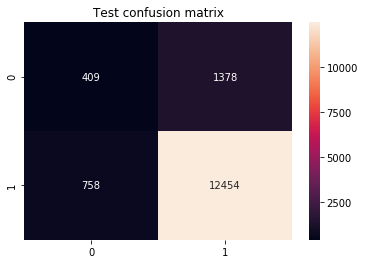

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(final_test)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

In [57]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the knn for bag of words is",scr[0])
print("recall of the knn for bag of words is",scr[1])
print("fscore of the knn for bag of words is",scr[2])

precision of the knn for bag of words is 0.834859598607985
recall of the knn for bag of words is 0.8575905060337355
fscore of the knn for bag of words is 0.8442781164447106


In [58]:
pred_pr = knn_optimal.predict_proba(final_counts)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1]) 
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (3, acc_tr))


The roc_auc_score of the knn classifier for k = 3 is 0.935982


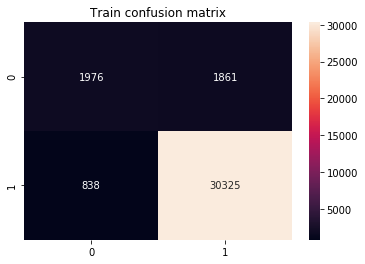

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(final_counts)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

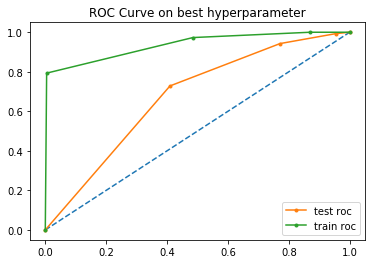

In [60]:
probs_test = knn_optimal.predict_proba(final_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = knn_optimal.predict_proba(final_counts)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [64]:
ptab.add_row(["bow","brute force", 3, acc_tr])

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>


The optimal number of k is 5.


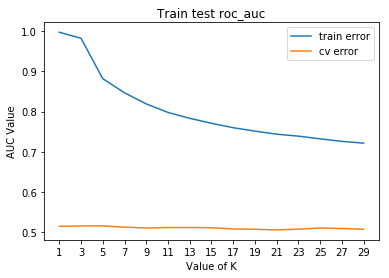

AUC for each K value is :  [0.515 0.515 0.516 0.512 0.51  0.511 0.511 0.511 0.508 0.507 0.506 0.507
 0.51  0.509 0.507]


In [62]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    score = cross_validate(knn, final_tf_idf, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [65]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(final_tf_idf, y_tr)
pred_pr = knn_optimal.predict_proba(final_tf_test)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe accuracy_score of the knn classifier for k = %d is %f' % (optimal_k, acc))


The accuracy_score of the knn classifier for k = 5 is 0.516482


#### confusion matrix on train dataset

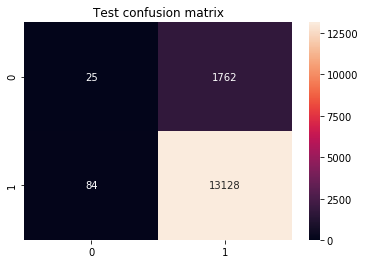

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(final_tf_test)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [67]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the knn for bag of words is",scr[0])
print("recall of the knn for bag of words is",scr[1])
print("fscore of the knn for bag of words is",scr[2])

precision of the knn for bag of words is 0.8039487697094791
recall of the knn for bag of words is 0.8769251283418894
fscore of the knn for bag of words is 0.8261376644423317


#### confusion matrix on train dataset

In [68]:
pred_pr = knn_optimal.predict_proba(final_tf_idf)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1])
print('\nThe accuracy of the knn classifier for k = %d is %f' % (optimal_k, acc_tr))


The accuracy of the knn classifier for k = 5 is 0.877668


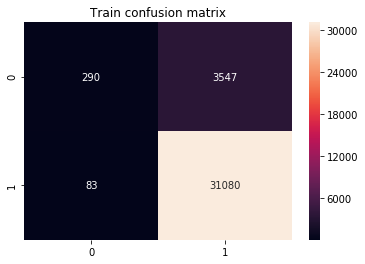

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(final_tf_idf)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

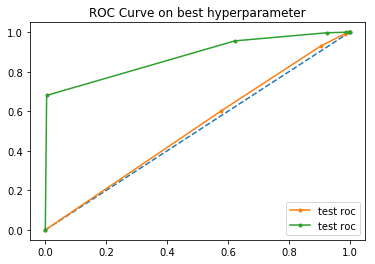

In [70]:
probs_tr = knn_optimal.predict_proba(final_tf_idf)
probs_test = knn_optimal.predict_proba(final_tf_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="test roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [71]:
ptab.add_row(["tfidf","brute force", optimal_k, acc_tr])

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>


The optimal number of k is 29.


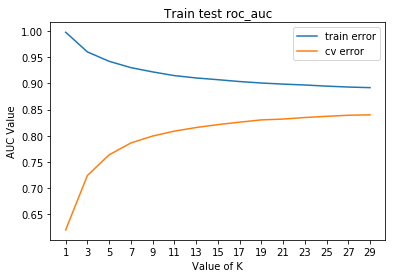

AUC for each K value is :  [0.62  0.724 0.763 0.786 0.799 0.809 0.816 0.821 0.826 0.83  0.832 0.835
 0.837 0.839 0.84 ]


In [72]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    score = cross_validate(knn, sent_vectors, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [73]:
knn_optimal = KNeighborsClassifier(n_neighbors=7)
knn_optimal.fit(sent_vectors, y_tr)
pred_pr = knn_optimal.predict_proba(test_vectors)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (optimal_k, acc))


The roc_auc_score of the knn classifier for k = 29 is 0.770359


#### confusion matrix on train dataset

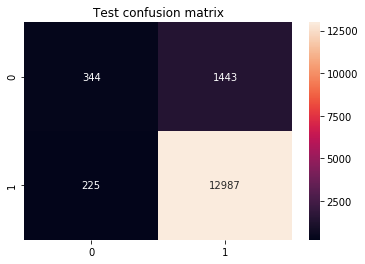

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(test_vectors)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a = sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [75]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the knn for bag of words is",scr[0])
print("recall of the knn for bag of words is",scr[1])
print("fscore of the knn for bag of words is",scr[2])

precision of the knn for bag of words is 0.8648020237084347
recall of the knn for bag of words is 0.8887925861724115
fscore of the knn for bag of words is 0.8624967843122922


#### confusion matrix on train dataset

In [78]:
pred_pr = knn_optimal.predict_proba(sent_vectors)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (7, acc))


The roc_auc_score of the knn classifier for k = 7 is 0.770359


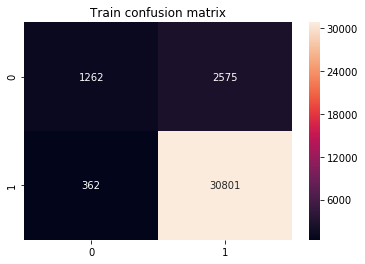

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(sent_vectors)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

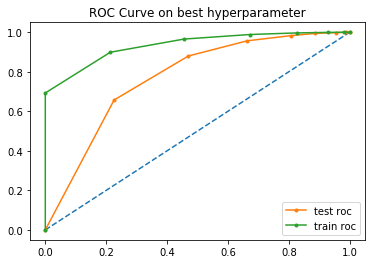

In [80]:
probs_tr = knn_optimal.predict_proba(sent_vectors)
probs_test = knn_optimal.predict_proba(test_vectors)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [81]:
ptab.add_row(["Avg w2v","brute force", 7, acc_tr])

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>


The optimal number of k is 29.


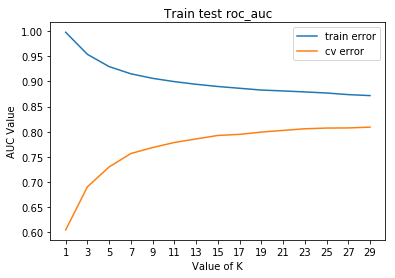

AUC for each K value is :  [0.605 0.691 0.73  0.757 0.769 0.779 0.786 0.793 0.795 0.799 0.803 0.806
 0.807 0.808 0.809]


In [82]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="brute")
    score = cross_validate(knn, tfidf_sent_vectors, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [84]:
knn_optimal = KNeighborsClassifier(n_neighbors=7)
knn_optimal.fit(tfidf_sent_vectors, y_tr)
pred_pr = knn_optimal.predict_proba(tfidf_test_vectors)
acc = roc_auc_score(y_test, pred_pr[:,1]) * 100
print('\nThe roc_auc_score of the knn classifier for k = %d is %f%%' % (7, acc))


The roc_auc_score of the knn classifier for k = 7 is 74.203608%


#### confusion matrix on train dataset

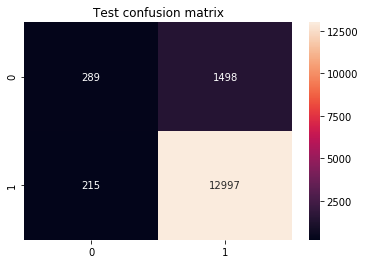

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(tfidf_test_vectors)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [86]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the knn for bag of words is",scr[0])
print("recall of the knn for bag of words is",scr[1])
print("fscore of the knn for bag of words is",scr[2])

precision of the knn for bag of words is 0.8581426352533439
recall of the knn for bag of words is 0.8857923861590773
fscore of the knn for bag of words is 0.8564575054509866


#### confusion matrix on train dataset

In [87]:
pred_pr = knn_optimal.predict_proba(tfidf_sent_vectors)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1]) 
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (7, acc_tr))


The roc_auc_score of the knn classifier for k = 7 is 0.917720


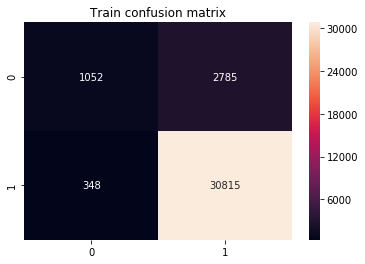

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(tfidf_sent_vectors)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

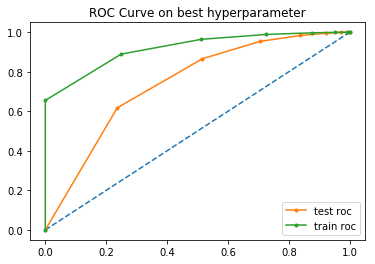

In [89]:
probs_tr = knn_optimal.predict_proba(tfidf_sent_vectors)
probs_test = knn_optimal.predict_proba(tfidf_test_vectors)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [90]:
ptab.add_row(["tfidf_w2v","brute force", 7, acc_tr])

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [139]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 50
pca_final_counts = pca.fit_transform(final_counts.todense())
pca_final_test = pca.fit_transform(final_test.todense())
print("shape of pca_final_count shape is = ", pca_final_counts.shape)
print("shape of pca_final_test shape is = ", pca_final_test.shape)

shape of pca_final_count shape is =  (14000, 50)
shape of pca_final_test shape is =  (5999, 50)



The optimal number of k is 29.


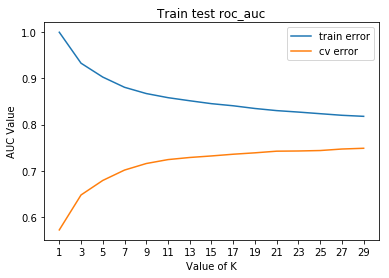

AUC for each K value is :  [0.573 0.648 0.679 0.702 0.716 0.724 0.729 0.732 0.736 0.739 0.743 0.743
 0.744 0.747 0.749]


In [140]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree")
    score = cross_validate(knn, pca_final_counts, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [141]:
knn_optimal = KNeighborsClassifier(n_neighbors=9,algorithm="kd_tree")
knn_optimal.fit(pca_final_counts, y_tr)
pred_pr = knn_optimal.predict_proba(pca_final_test)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe accuracy of the knn classifier for k = %d is %f' % (9, acc))


The accuracy of the knn classifier for k = 9 is 0.600034


#### confusion matrix on train dataset

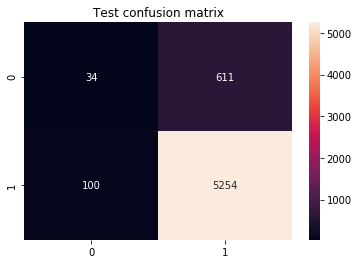

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(pca_final_test)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [143]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the kd_tree knn for bag of words is",scr[0])
print("recall of the kd_tree knn for bag of words is",scr[1])
print("fscore of the kd_tree knn for bag of words is",scr[2])

precision of the kd_tree knn for bag of words is 0.8267863524793503
recall of the kd_tree knn for bag of words is 0.8814802467077846
fscore of the kd_tree knn for bag of words is 0.8453067463012189


#### confusion matrix on train dataset

In [145]:
pred_pr = knn_optimal.predict_proba(pca_final_counts)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1]) * 100
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (9, acc))


The roc_auc_score of the knn classifier for k = 9 is 0.600034


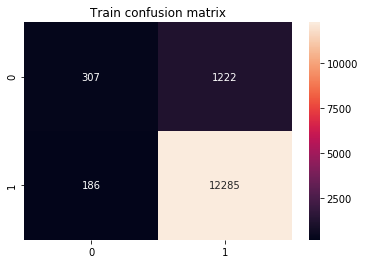

In [146]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(pca_final_counts)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

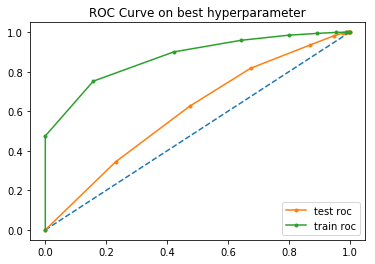

In [147]:
probs_tr = knn_optimal.predict_proba(pca_final_counts)
probs_test = knn_optimal.predict_proba(pca_final_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [148]:
ptab.add_row(["bow","kd_tree", 9, acc_tr])

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [149]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 50
pca_final_tf_idf = pca.fit_transform(final_tf_idf.todense())
pca_final_tf_test = pca.fit_transform(final_tf_test.todense())
print("shape of pca_final_count shape is = ", pca_final_tf_idf.shape)
print("shape of pca_final_test shape is = ", pca_final_test.shape)

shape of pca_final_count shape is =  (14000, 50)
shape of pca_final_test shape is =  (5999, 50)



The optimal number of k is 29.


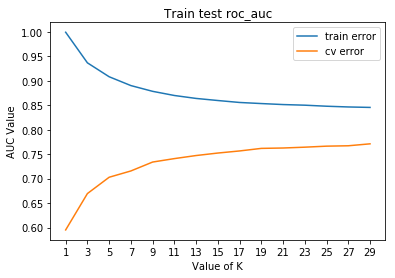

AUC for each K value is :  [0.595 0.669 0.703 0.716 0.734 0.741 0.747 0.752 0.757 0.762 0.763 0.764
 0.766 0.767 0.771]


In [150]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree")
    score = cross_validate(knn, pca_final_tf_idf, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [151]:
knn_optimal = KNeighborsClassifier(n_neighbors=9,algorithm="kd_tree")
knn_optimal.fit(pca_final_tf_idf, y_tr)
pred_pr = knn_optimal.predict_proba(pca_final_tf_test)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (optimal_k, 9))


The roc_auc_score of the knn classifier for k = 29 is 9.000000


#### confusion matrix on train dataset

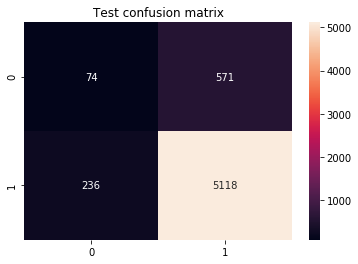

In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(pca_final_tf_test)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [153]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the kd_tree knn for bag of words is",scr[0])
print("recall of the kd_tree knn for bag of words is",scr[1])
print("fscore of the kd_tree knn for bag of words is",scr[2])

precision of the kd_tree knn for bag of words is 0.8285699952708169
recall of the kd_tree knn for bag of words is 0.8654775795965994
fscore of the kd_tree knn for bag of words is 0.8439237664300353


#### confusion matrix on train dataset

In [154]:
pred_pr = knn_optimal.predict_proba(pca_final_tf_idf)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (9, acc_tr))


The roc_auc_score of the knn classifier for k = 9 is 0.879835


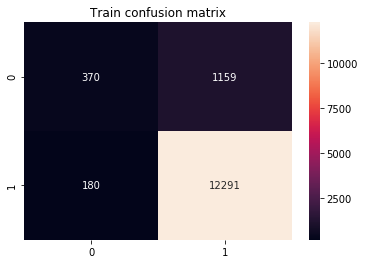

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(pca_final_tf_idf)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

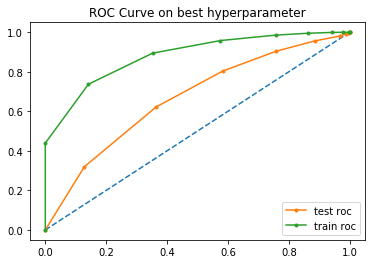

In [156]:
probs_tr = knn_optimal.predict_proba(pca_final_tf_idf)
probs_test = knn_optimal.predict_proba(pca_final_tf_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [157]:
ptab.add_row(["tfidf","kd_tree", 9, acc_tr])

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>


The optimal number of k is 29.


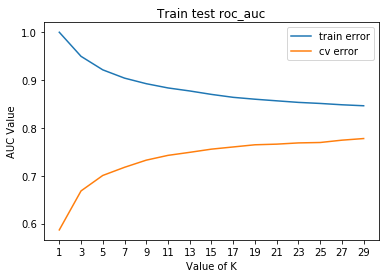

AUC for each K value is :  [0.587 0.668 0.701 0.718 0.733 0.743 0.749 0.756 0.76  0.765 0.766 0.769
 0.769 0.774 0.778]


In [158]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree")
    score = cross_validate(knn, sent_vectors, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [159]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm="kd_tree")
knn_optimal.fit(sent_vectors, y_tr)
pred_pr = knn_optimal.predict_proba(test_vectors)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (optimal_k, acc))


The roc_auc_score of the knn classifier for k = 29 is 0.777747


#### confusion matrix on train dataset

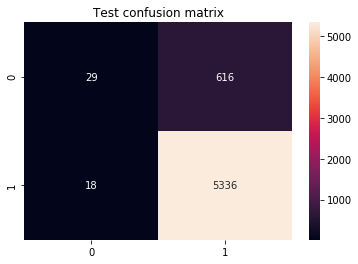

In [160]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(test_vectors)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [161]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the kd_tree knn for bag of words is",scr[0])
print("recall of the kd_tree knn for bag of words is",scr[1])
print("fscore of the kd_tree knn for bag of words is",scr[2])

precision of the kd_tree knn for bag of words is 0.8664558273629758
recall of the kd_tree knn for bag of words is 0.8943157192865477
fscore of the kd_tree knn for bag of words is 0.8514464982667248


#### confusion matrix on train dataset

In [162]:
pred_pr = knn_optimal.predict_proba(sent_vectors)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (optimal_k, acc))


The roc_auc_score of the knn classifier for k = 29 is 0.777747


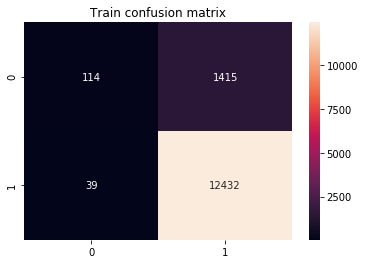

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(sent_vectors)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

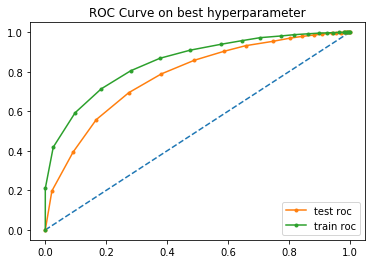

In [164]:
probs_tr = knn_optimal.predict_proba(sent_vectors)
probs_test = knn_optimal.predict_proba(test_vectors)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [165]:
ptab.add_row(["avg_w2v","kd_tree", optimal_k, acc_tr])

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>


The optimal number of k is 29.


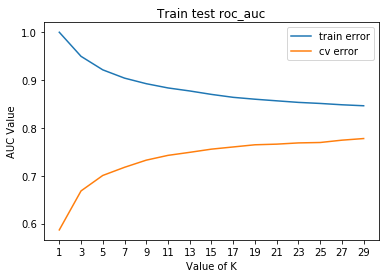

AUC for each K value is :  [0.587 0.668 0.701 0.718 0.733 0.743 0.749 0.756 0.76  0.765 0.766 0.769
 0.769 0.774 0.778]


In [166]:
from sklearn.model_selection import cross_validate
neighbors = [i for i in range(1,30,2)]
cv_scores =[]
train_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree")
    score = cross_validate(knn, sent_vectors, y_tr, cv=3, scoring='roc_auc')
    cv_scores.append(score['test_score'])
    train_scores.append(score['train_score'])
cv_scores = np.mean(np.array(cv_scores), axis = 1)
train_scores = np.mean(np.array(train_scores), axis = 1)
optimal_k = neighbors[np.argmax(cv_scores)]
print('\nThe optimal number of k is %d.' % optimal_k)
vals = [str(x) for x in neighbors]
plt.plot(vals, train_scores,label="train error")
plt.plot(vals, cv_scores,label="cv error")
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('AUC Value')
plt.title('Train test roc_auc')
plt.show()
print("AUC for each K value is : ", np.round(cv_scores,3)) 

In [182]:
knn_optimal = KNeighborsClassifier(n_neighbors=11,algorithm="kd_tree")
knn_optimal.fit(tfidf_sent_vectors, y_tr)
pred_pr = knn_optimal.predict_proba(tfidf_test_vectors)
acc = roc_auc_score(y_test, pred_pr[:,1])
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (11, acc))


The roc_auc_score of the knn classifier for k = 11 is 0.714110


#### confusion matrix on train dataset

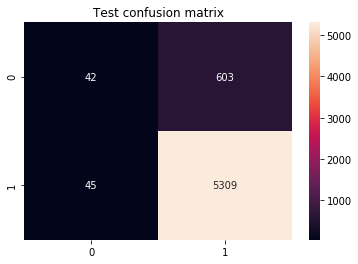

In [183]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(tfidf_test_vectors)
cf_matrix=confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Test confusion matrix")

#### precision recall and f1-score values

In [184]:
from sklearn.metrics import precision_recall_fscore_support
scr=precision_recall_fscore_support(y_test, pred, average='weighted')
print("precision of the kd_tree knn for bag of words is",scr[0])
print("recall of the kd_tree knn for bag of words is",scr[1])
print("fscore of the kd_tree knn for bag of words is",scr[2])

precision of the kd_tree knn for bag of words is 0.8533577338092271
recall of the kd_tree knn for bag of words is 0.8919819969994999
fscore of the kd_tree knn for bag of words is 0.8534862427441764


#### confusion matrix on train dataset

In [185]:
pred_pr = knn_optimal.predict_proba(tfidf_sent_vectors)
acc_tr = roc_auc_score(y_tr, pred_pr[:,1]) 
print('\nThe roc_auc_score of the knn classifier for k = %d is %f' % (11, acc))


The roc_auc_score of the knn classifier for k = 11 is 0.714110


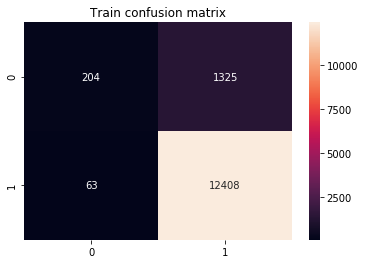

In [186]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
pred = knn_optimal.predict(tfidf_sent_vectors)
cf_matrix=confusion_matrix(y_tr, pred)
df_cm = pd.DataFrame(cf_matrix,range(0,2),range(0,2))
a=sn.heatmap(df_cm, annot=True,fmt='g').set_title("Train confusion matrix")

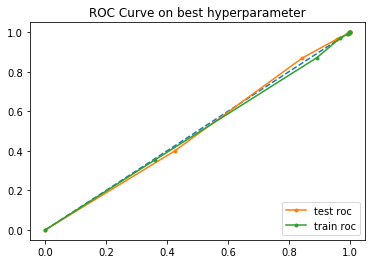

In [187]:
probs_tr = knn_optimal.predict_proba(pca_final_counts)
probs_test = knn_optimal.predict_proba(pca_final_test)
probs_test = probs_test[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test)
probs_tr = probs_tr[:, 1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, probs_tr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_test, tpr_test, marker='.',label="test roc")
plt.plot(fpr_tr, tpr_tr, marker='.',label="train roc")
plt.title('ROC Curve on best hyperparameter')
plt.legend(loc="lower right")
plt.show()

In [188]:
ptab.add_row(["tfidf_w2v","kd_tree", 11, acc_tr])

# [6] Conclusions

In [189]:
print(ptab)

+------------+-------------+-----------------+--------------------+
| Vectorizer |    Model    | Hyper parameter |        AUC         |
+------------+-------------+-----------------+--------------------+
|    bow     | brute force |        3        | 0.9359818443433671 |
|   tfidf    | brute force |        5        | 0.8776677752750548 |
|  Avg w2v   | brute force |        7        | 0.9335905698864649 |
| tfidf_w2v  | brute force |        7        | 0.9177196748638488 |
|    bow     |   kd_tree   |        9        | 87.22236897647016  |
|   tfidf    |   kd_tree   |        9        | 0.8798353317695746 |
|  avg_w2v   |   kd_tree   |        29       |  0.85030544899484  |
| tfidf_w2v  |   kd_tree   |        11       | 0.8704372823826357 |
+------------+-------------+-----------------+--------------------+
